In [1]:
%matplotlib notebook

In [3]:
import os
import pprint
import copy
import hydra
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from hydra import initialize, initialize_config_module, initialize_config_dir, compose
from typing import Dict, Tuple

from omegaconf import OmegaConf
from torch.utils.data.dataloader import DataLoader

from research.mtm.models.mtm_model import MTM, make_plots_with_masks
from research.mtm.tokenizers.base import Tokenizer, TokenizerManager
from research.mtm.train import main, create_eval_logs_states

In [4]:
with initialize(version_base=None, config_path="research/mtm"):
    cfg = compose(config_name="config.yaml", overrides=["+exp_mtm=sinusoid_cont"])

In [5]:
os.makedirs("sinusoid_exp", exist_ok=True)
os.chdir("sinusoid_exp")
print(os.getcwd())

/home/jiale/mtm/sinusoid_exp


In [20]:
# train model
main(cfg)

INFO:research.mtm.distributed_utils:Loading distributed job info from submitit...
INFO:research.mtm.distributed_utils:Loading distributed job info from environment variables...
INFO:root:Working directory: /home/jiale/mtm/sinusoid_exp
INFO:root:Train set size = 10000
INFO:root:Validation set size = 512
INFO:root:Tokenizers: {'states': ContinuousTokenizer()}
INFO:root:[stopwatch: data loader] Starting!
INFO:root:[stopwatch: data loader] Completed in 0.0006165504455566406 seconds


RunConfig(seed=0,
          batch_size=1024,
          n_workers=10,
          log_every=100,
          print_every=1000,
          eval_every=500,
          save_every=10000,
          device='cuda',
          mask_ratios=[0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1.0],
          mask_patterns=['AUTO_MASK'],
          warmup_steps=100,
          num_train_steps=1010,
          learning_rate=0.0001,
          weight_decay=0.005,
          traj_length=16,
          mode_weights=[0.2, 0.1, 0.7],
          tsp_ratio=1)


ERROR:tornado.general:SEND Error: Host unreachable


KeyboardInterrupt: 

In [18]:
# load model
def get_mtm_model(
    path: str,
) -> Tuple[MTM, TokenizerManager, Dict[str, Tuple[int, int]]]:
    def _get_dataset(dataset, traj_length):
        return hydra.utils.call(dataset, seq_steps=traj_length)

    # find checkpoints in the directory
    steps = []
    names = []
    paths_ = os.listdir(path)
    for name in [os.path.join(path, n) for n in paths_ if "pt" in n]:
        step = os.path.basename(name).split("_")[-1].split(".")[0]
        steps.append(int(step))
        names.append(name)
    ckpt_path = names[np.argmax(steps)]

    hydra_cfg = OmegaConf.load(os.path.join(path, "config.yaml"))
    cfg = hydra.utils.instantiate(hydra_cfg.args)
    train_dataset, val_dataset = _get_dataset(hydra_cfg.dataset, cfg.traj_length)
    tokenizers: Dict[str, Tokenizer] = {
        k: hydra.utils.call(v, key=k, train_dataset=train_dataset)
        for k, v in hydra_cfg.tokenizers.items()
    }
    tokenizer_manager = TokenizerManager(tokenizers)
    discrete_map: Dict[str, bool] = {}
    for k, v in tokenizers.items():
        discrete_map[k] = v.discrete
    train_loader = DataLoader(
        train_dataset,
        # shuffle=True,
        pin_memory=True,
        batch_size=cfg.batch_size,
        num_workers=cfg.n_workers,
    )
    train_batch = next(iter(train_loader))
    tokenized = tokenizer_manager.encode(train_batch)
    data_shapes = {}
    for k, v in tokenized.items():
        data_shapes[k] = v.shape[-2:]

    model_config = hydra.utils.instantiate(hydra_cfg.model_config)
    model = MTM(data_shapes, cfg.traj_length, model_config)
    model.load_state_dict(torch.load(ckpt_path)["model"])
    model.eval()

    # freeze the model
    for param in model.parameters():
        param.requires_grad = False

    return model, tokenizer_manager, data_shapes, val_dataset



In [19]:
model, tokenizer_manager, data_shapes, val_dataset = get_mtm_model(".")

In [16]:
val_sampler = torch.utils.data.SequentialSampler(val_dataset)
val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    num_workers=0,
    sampler=val_sampler,
)
val_batch = next(iter(val_loader)) # [32, 16, 1]

# visualize the data
L = val_batch["states"].shape[1]
for states in val_batch["states"][:4]:
    plt.plot(np.arange(L), states, "-")
plt.show()

/tmp/ipykernel_26420/1616187878.py:14: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [10]:
val_batch = {
    k: v.to("cpu", non_blocking=True) for k, v in val_batch.items()
}
device = val_batch["states"].device
seq_len = val_batch["states"].shape[1]

In [17]:
# generate masks
obs_mask = np.ones(seq_len)
obs_mask[seq_len // 2 + 2 :] = 0 # mask out future observations
obs_use_mask_list = [obs_mask]

masks_list = []
for obs_mask in obs_use_mask_list:
    masks_list.append({"states": torch.from_numpy(obs_mask).to(device)})

prefixs = ["prediction"]
logs = make_plots_with_masks(model, val_batch, tokenizer_manager, masks_list, prefixs, batch_idxs = (0, 1))

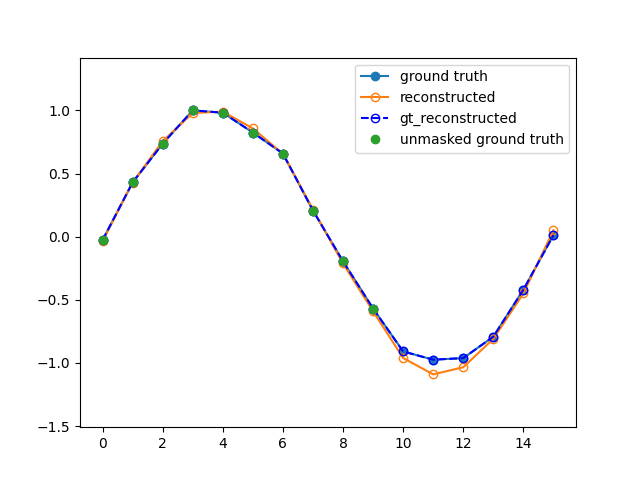

In [12]:
# visualize prediction
logs["prediction_eval/batch=0|0_states"].image

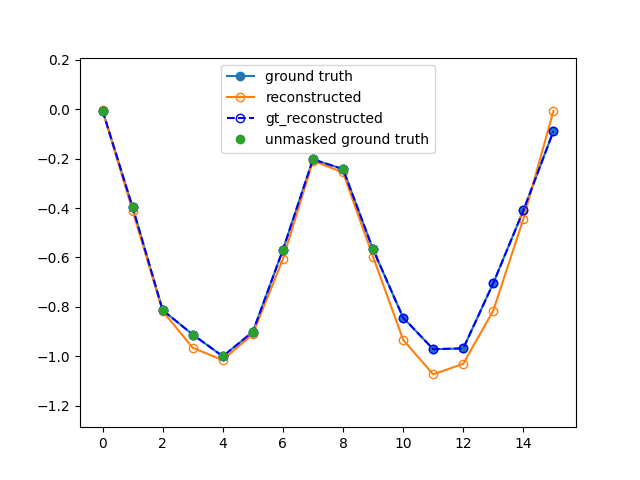

In [13]:
# visualize prediction
logs["prediction_eval/batch=1|0_states"].image